# 🧠 MNIST Handwritten Digit Classification using CNN (PyTorch)

**Goal:**  
Build and train a Convolutional Neural Network (CNN) to classify handwritten digits (0–9) using the MNIST dataset.  
Achieve at least **95% test accuracy** and visualize model predictions.

**Framework:** PyTorch  
**Dataset:** MNIST (via `torchvision.datasets`)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)


Running on device: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

val_size = 6000
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (bn_fc): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.

In [4]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0.0
num_epochs = 10

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mnist_cnn_torch_best.pth")

model.load_state_dict(torch.load("mnist_cnn_torch_best.pth"))


Epoch 1/10 - Train acc: 0.9693, Val acc: 0.9865
Epoch 2/10 - Train acc: 0.9866, Val acc: 0.9908
Epoch 3/10 - Train acc: 0.9904, Val acc: 0.9883
Epoch 4/10 - Train acc: 0.9912, Val acc: 0.9908
Epoch 5/10 - Train acc: 0.9929, Val acc: 0.9915
Epoch 6/10 - Train acc: 0.9943, Val acc: 0.9918
Epoch 7/10 - Train acc: 0.9946, Val acc: 0.9933
Epoch 8/10 - Train acc: 0.9955, Val acc: 0.9918
Epoch 9/10 - Train acc: 0.9959, Val acc: 0.9930
Epoch 10/10 - Train acc: 0.9961, Val acc: 0.9927


<All keys matched successfully>

In [6]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")



✅ Test Accuracy: 0.9936


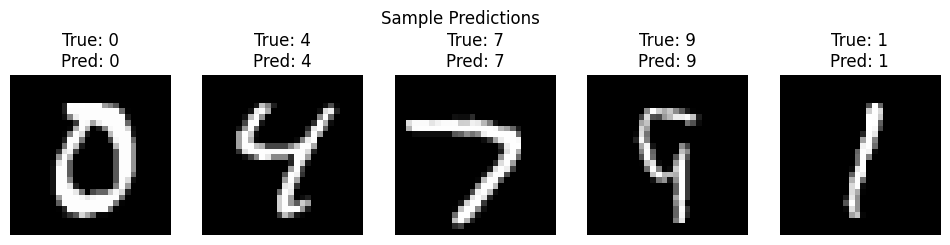

In [7]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = outputs.max(1)

fig = plt.figure(figsize=(12,3))
for i, idx in enumerate(random.sample(range(images.size(0)), 5)):
    ax = fig.add_subplot(1,5,i+1)
    img = images[idx].cpu().squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {labels[idx].item()}\nPred: {preds[idx].item()}")
    ax.axis('off')
plt.suptitle("Sample Predictions")
plt.show()
